## Deep CNN learning to differentiate african and asian elephants

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB3


C:\Users\calla\OneDrive\Desktop\Computer Science Projects\CNN Image Classifier\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
IMG_SIZE = (300,300)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    validation_split = 0.2,
    rotation_range = 15,
    zoom_range = 0.15,
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    "data/train",
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    subset = "training"
)

val_generator = train_datagen.flow_from_directory(
    "data/train",
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    subset = "validation"
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    "data/test",
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    shuffle = False
)



Found 672 images belonging to 2 classes.
Found 168 images belonging to 2 classes.
Found 188 images belonging to 2 classes.


In [3]:
base_model = EfficientNetB3(
    weights = "imagenet",
    include_top = False,
    input_shape = (300, 300, 3)
)

base_model.trainable = False

In [4]:
model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(128, activation = "relu"),
    Dropout(0.5),
    Dense(1, activation = "sigmoid")
])

In [5]:
model.compile(
    optimizer = Adam(learning_rate = 1e-5),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [6]:
callbacks = [
    EarlyStopping(
        monitor = "val_loss",
        patience = 5,
        restore_best_weights = True
    ),
    ModelCheckpoint(
        "elephant_classifier.keras",
        monitor = "val_loss",
        save_best_only = True
    )
]

In [7]:
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 30,
    callbacks = callbacks
)

base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False
    
model.compile(
    optimizer = Adam(learning_rate = 1e-5),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

history_finetune = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 15,
    callbacks = callbacks
)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 51s 980ms/step - accuracy: 0.4985 - loss: 0.7126 - val_accuracy: 0.5179 - val_loss: 0.6916
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 767ms/step - accuracy: 0.4955 - loss: 0.7110 - val_accuracy: 0.5714 - val_loss: 0.6779
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 741ms/step - accuracy: 0.5580 - loss: 0.6921 - val_accuracy: 0.5417 - val_loss: 0.6782
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 838ms/step - accuracy: 0.5804 - loss: 0.6812 - val_accuracy: 0.6250 - val_loss: 0.6595
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 877ms/step - accuracy: 0.6057 - loss: 0.6649 - val_accuracy: 0.6845 - val_loss: 0.6534
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 743ms/step - accuracy: 0.6086 - loss: 0.6622 - val_accuracy: 0.6548 - val_loss: 0.6543
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 768ms/step - accuracy: 0.6310 - loss: 0.6684 - val_accuracy: 0.6250 - val_loss: 0.6458
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 772ms/step - accuracy: 0.6667 - loss: 0.6471 - val_accu

In [8]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.3f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 667ms/step - accuracy: 0.9149 - loss: 0.3954
Test Accuracy: 0.915


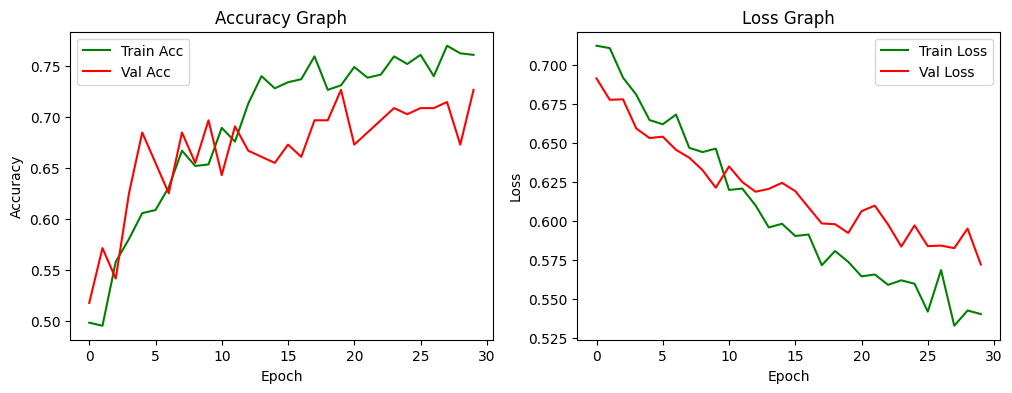

In [9]:
def plot_history(history):
    
    plt.figure(figsize = (12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label = "Train Acc", color = "green")
    plt.plot(history.history["val_accuracy"], label = "Val Acc", color = "red")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Graph")

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label = "Train Loss", color = "green")
    plt.plot(history.history["val_loss"], label = "Val Loss", color = "red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Graph")

    plt.show()

plot_history(history)